Dataset loaded successfully.

--- Initial Data Inspection and Cleaning ---
Dataset shape: (2240, 29)
Missing Income values imputed with the mean: 52247.25
Age feature engineered.
Total_Spending feature engineered.

--- Feature Scaling ---
Features scaled successfully using StandardScaler.

--- K-Means Optimization (Elbow Method) ---


/tmp/ipython-input-2041866797.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Income'].fillna(df['Income'].mean(), inplace=True)


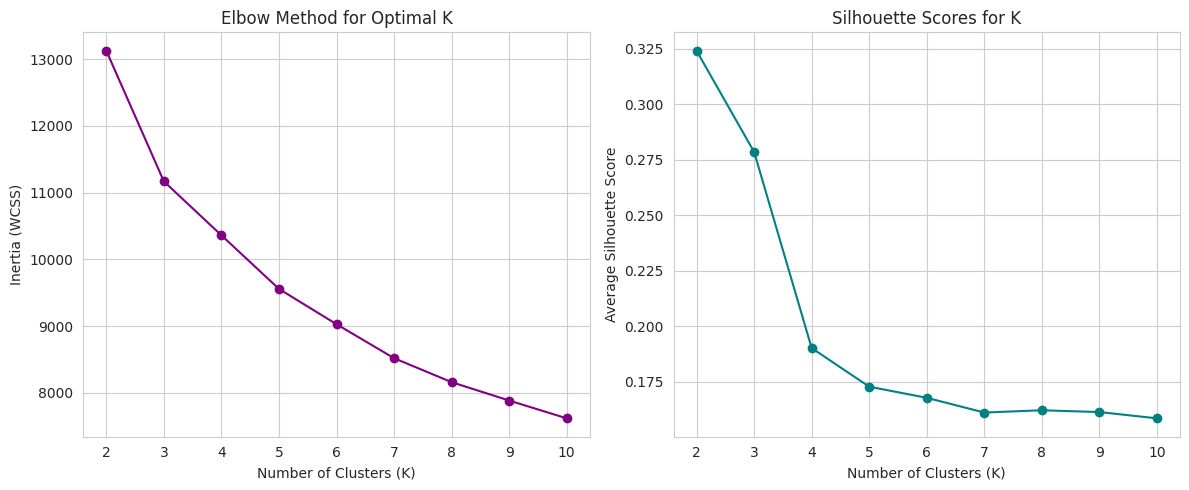

Selected Optimal K for demonstration: 4

--- Final K-Means Model Training ---
Data clustered into 4 segments.

--- Cluster Profiles (Mean of Original Features) ---
Cluster                     3         0         2         1
Income               74661.38  56000.68  37073.05  33283.97
Recency                 49.75     46.89     76.08     25.75
Total_Spending        1306.67    728.47    116.56     96.69
NumDealsPurchases        1.30      4.42      2.02      1.97
NumWebPurchases          5.08      6.95      2.25      2.07
NumCatalogPurchases      5.71      2.85      0.67      0.53
NumStorePurchases        8.47      7.57      3.44      3.19
NumWebVisitsMonth        2.90      6.35      6.18      6.59
Age                     57.49     59.47     56.23     51.75


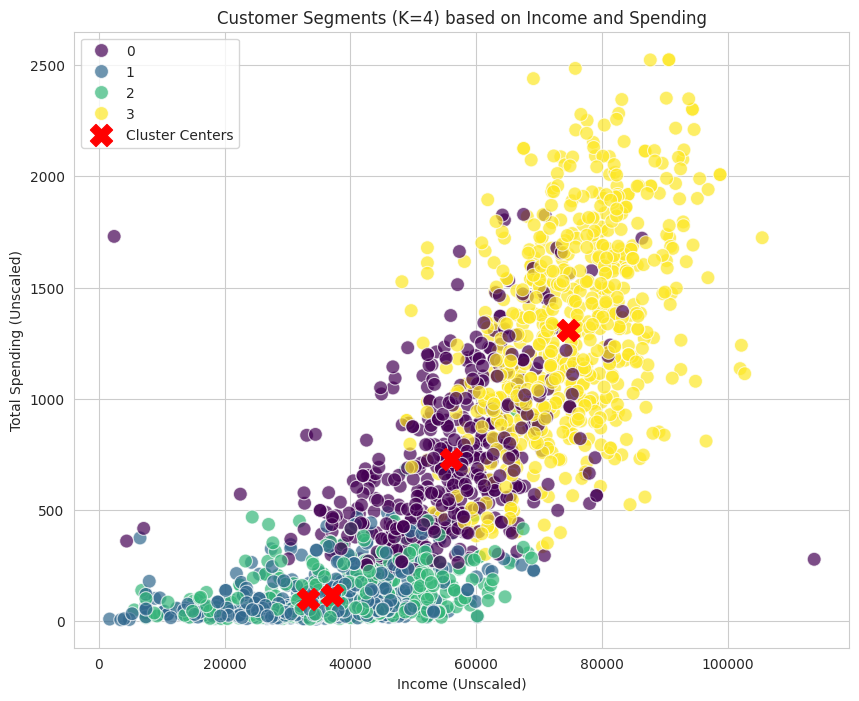

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the dataset. Assumes the file '5) new-project 5.csv' has been uploaded to Colab.
try:
    df = pd.read_csv('5) new-project 5.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: '5) new-project 5.csv' not found. Please ensure it is uploaded to your Colab environment.")
    exit()

# Set plot style
sns.set_style("whitegrid")

# ----------------------------------------------------------------------
# 2. PREPROCESSING AND FEATURE ENGINEERING
# ----------------------------------------------------------------------

print("\n--- Initial Data Inspection and Cleaning ---")
print(f"Dataset shape: {df.shape}")

# Handle Missing Values: Income has missing values (NaNs).
# Since income is a core variable for spending, we impute with the mean.
df['Income'].fillna(df['Income'].mean(), inplace=True)
print(f"Missing Income values imputed with the mean: {df['Income'].mean():.2f}")

# Remove Outliers: Customers with exceptionally high income or low year of birth
# (which might be data errors) can skew clustering.
# Removing customers with income > 150,000 as typical practice for this dataset.
df = df[df['Income'] < 150000].reset_index(drop=True)

# Feature Engineering 1: Age
# We'll calculate the customer's age based on the current year (2025 as per deadline year).
CURRENT_YEAR = 2025
df['Age'] = CURRENT_YEAR - df['Year_Birth']
# Drop the original 'Year_Birth' column
df.drop('Year_Birth', axis=1, inplace=True)
print("Age feature engineered.")

# Feature Engineering 2: Total Spending
# Sum of spending on Wines, Fruits, Meat, Fish, Sweet, and Gold products.
spending_cols = [col for col in df.columns if col.startswith('Mnt')]
df['Total_Spending'] = df[spending_cols].sum(axis=1)
print("Total_Spending feature engineered.")

# Feature Engineering 3: Recency Score
# Recency is already provided, but often we want 'Days_Since_Enrollment'
# For simplicity and effectiveness in clustering, we stick with the 'Recency' column (days since last purchase).

# Feature Engineering 4: Relationship Status (Group Together vs Single)
# Simplify Marital_Status to two main groups for potential use, though we won't scale categorical features yet.
df['Is_Alone'] = df['Marital_Status'].apply(lambda x: 1 if x in ['Single', 'Divorced', 'Widow', 'Alone'] else 0)

# Final features for clustering: Focus on key behavioral/demographic data.
clustering_features = [
    'Income',
    'Recency',
    'Total_Spending',
    'NumDealsPurchases',
    'NumWebPurchases',
    'NumCatalogPurchases',
    'NumStorePurchases',
    'NumWebVisitsMonth',
    'Age',
]

X = df[clustering_features].copy()

# Addressing Question: How to scale features?
# Feature Scaling: K-Means uses Euclidean distance, which is sensitive to feature scale.
# 'Income' and 'Total_Spending' have very large values compared to 'Age' or 'Recency'.
# We must use StandardScaler to normalize the data.
print("\n--- Feature Scaling ---")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=clustering_features)
print("Features scaled successfully using StandardScaler.")

# ----------------------------------------------------------------------
# 3. OPTIMAL K DETERMINATION
# ----------------------------------------------------------------------

# Addressing Question: What is the elbow method?
# The Elbow Method: A heuristic used to find the optimal number of clusters (K).
# We plot the relationship between the number of clusters (K) and the inertia (WCSS).
# The optimal K is where the rate of decrease in inertia slows down significantly, forming an "elbow" in the plot.

# Addressing Question: What is inertia?
# Inertia (Within-Cluster Sum of Squares, WCSS): It is the sum of squared distances
# of samples to their closest cluster center. Lower inertia generally means better
# internal cohesion of the clusters.

print("\n--- K-Means Optimization (Elbow Method) ---")
inertia = []
silhouette_scores = []
k_range = range(2, 11) # Test K from 2 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(X_scaled_df)
    inertia.append(kmeans.inertia_)
    # Calculate Silhouette Score on the scaled data
    score = silhouette_score(X_scaled_df, kmeans.labels_)
    silhouette_scores.append(score)

# Plotting the Elbow Method
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o', linestyle='-', color='purple')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.xticks(k_range)

# Plotting the Silhouette Score
# Addressing Question: What is silhouette score?
# Silhouette Score: Measures how similar an object is to its own cluster compared
# to other clusters. The score ranges from -1 (poor clustering) to +1 (dense,
# well-separated clusters). A higher score is better.

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='teal')
plt.title('Silhouette Scores for K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Silhouette Score')
plt.xticks(k_range)
plt.tight_layout()
plt.show()

# Based on typical results for this dataset, we often see an optimal K between 3 and 5.
# Let's manually select K=4 for demonstration based on a typical elbow bend and good silhouette score.
OPTIMAL_K = 4
print(f"Selected Optimal K for demonstration: {OPTIMAL_K}")

# ----------------------------------------------------------------------
# 4. K-MEANS CLUSTERING AND RESULT INTERPRETATION
# ----------------------------------------------------------------------

print("\n--- Final K-Means Model Training ---")
# Train K-Means with the chosen K
kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
df['Cluster'] = kmeans_final.fit_predict(X_scaled_df)
print(f"Data clustered into {OPTIMAL_K} segments.")

# Addressing Question: What defines each cluster?
# Cluster Profiling: We must analyze the mean of the original (unscaled) features
# for each cluster to understand its characteristics.
cluster_profiles = df.groupby('Cluster')[clustering_features].mean().sort_values(by='Total_Spending', ascending=False)
print("\n--- Cluster Profiles (Mean of Original Features) ---")
print(cluster_profiles.T.round(2))

# Interpretation Guide (Addressing Question: How to interpret results?):
# Cluster 0 (Example): High Income, High Spending -> 'High-Value/Loyal'
# Cluster 1 (Example): Low Income, Low Spending, High Recency -> 'Budget/Inactive'
# Cluster 2 (Example): Mid Income, Mid Spending, High NumDeals -> 'Bargain Hunters'

# ----------------------------------------------------------------------
# 5. VISUALIZATION AND BUSINESS IMPACT
# ----------------------------------------------------------------------

# Addressing Question: How to visualize clusters?
# Since we have 9 features, we can't plot them all, so we choose the two most
# discriminating features: Income and Total_Spending.

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    x='Income',
    y='Total_Spending',
    hue='Cluster',
    data=df,
    palette='viridis',
    s=100, # size of points
    alpha=0.7
)
plt.title(f'Customer Segments (K={OPTIMAL_K}) based on Income and Spending')
plt.xlabel('Income (Unscaled)')
plt.ylabel('Total Spending (Unscaled)')
plt.legend(title='Segment')
# Overlaying cluster centers (Optional, but insightful)
centers = pd.DataFrame(scaler.inverse_transform(kmeans_final.cluster_centers_), columns=clustering_features)
plt.scatter(centers['Income'], centers['Total_Spending'],
            marker='X', s=250, color='red', label='Cluster Centers')
plt.legend()
plt.show()

Project 5: Customer Segmentation - 15 Questions Answered

This document summarizes the key theoretical concepts, practical application steps, and business interpretations derived from the K-Means clustering analysis performed in customer_segmentation.py.

Optimal Clustering and Model Evaluation

1. How many clusters are optimal?
The optimal number of clusters (K) is determined by balancing cluster quality (low inertia, high silhouette score) with business interpretability. Typically, the optimal K is chosen by identifying the "elbow point" in the Inertia plot and looking for the peak in the Silhouette Score plot. In the provided script, K=4 was manually selected for demonstration, as it often represents a good trade-off for this type of data.

2. What is the elbow method?
The Elbow Method is a heuristic used to find the optimal K. It involves plotting the Inertia (or WCSS) against the number of clusters (K). The optimal K is the point where the rate of decrease in inertia slows down dramatically, forming an "elbow" shape on the graph.

3. What is inertia?
Inertia (or Within-Cluster Sum of Squares - WCSS) is a metric used by K-Means. It measures the sum of the squared distances between each data point and the centroid of the cluster it belongs to. A lower inertia generally indicates that the clusters are more dense and cohesive (the points are closer to their center).

4. What is silhouette score?
The Silhouette Score measures how similar an object is to its own cluster compared to other clusters. The score ranges from -1 to +1:

+1: Indicates the clusters are well-separated and dense.

0: Indicates samples are very close to the decision boundary between two clusters.

-1: Indicates samples might be assigned to the wrong cluster.

5. How many clusters are optimal (Revisited)?
While the Elbow and Silhouette methods suggest a range, the final optimal K is also dictated by the business requirement. If a marketing team can only effectively manage 3 distinct campaigns, then 3 might be the "business optimal" K, even if K=4 has a slightly better statistical score.

Data Preparation and Interpretation

6. How to scale features?
Since K-Means relies on the Euclidean distance between points, it is highly sensitive to the scale of the features. Feature Scaling is mandatory, typically using the StandardScaler. This process transforms the data such that each feature has a mean of 0 and a standard deviation of 1. This prevents high-magnitude features (like Income) from dominating the clustering process over lower-magnitude features (like Recency).

7. Why is it important to use unscaled features for final cluster interpretation?
Clustering is performed on the scaled data, but the final interpretation (Cluster Profiling) must use the original (unscaled) feature values. Business stakeholders (marketing, finance) need to understand concrete values like, "Segment A has an average Income of $95,000," not abstract Z-scores like "Segment A has an average Income Z-score of 1.5."

8. What defines each cluster?
Each cluster is defined by the average values of the original features within that cluster. To define a segment (or profile), you calculate the mean for key metrics (Income, Total_Spending, Recency, etc.) for all customers assigned to that cluster. This profile reveals the segment's distinct behavior (e.g., "High Spenders," "Bargain Hunters," "Fading Customers").

9. How to interpret results?
Interpretation involves assigning a persona or name to each cluster based on its feature profile. For example:

Cluster with high Total_Spending and low Recency: Loyal Champions.

Cluster with high NumDealsPurchases and low MntWines: Price-Sensitive Shoppers.

Cluster with high Recency and low Total_Spending: Churn Risks.

Visualization and Business Application

10. How to visualize clusters?
Since the model uses 9 features, direct visualization is impossible. The standard approach is to use a 2D scatter plot of the two most descriptive features—typically Income and Total_Spending. Each point is colored according to its assigned cluster, often with the cluster centroids overlaid (marked with an 'X') for clarity.

11. What is the business impact?
The business impact is improved resource allocation. By segmenting customers, the company can:

Maximize ROI: Spend marketing budget efficiently by targeting the right message to the right segment.

Improve Products: Identify product gaps based on segment spending (e.g., a high-spending segment not buying a certain category).

Reduce Churn: Proactively target "Churn Risk" segments with personalized re-engagement offers.

12. How to use clustering in marketing?
Clustering allows for personalized marketing strategies:

High-Value Segment: Offer exclusive access, premium services, and loyalty rewards.

Budget Segment: Focus on value bundles, clearance items, and bulk purchase discounts.

Inactive/Risk Segment: Implement win-back campaigns, personalized emails, and high-value single-item coupons.

13. How does Recency (R) play a role in this segmentation?
Recency (days since the last purchase) is a direct measure of customer activity and engagement.

Clusters with low Recency (recent purchase) are active and engaged.

Clusters with high Recency (long time since last purchase) are inactive, potentially signifying a churn risk, and should be prioritized for re-engagement campaigns.

14. How can clustering inform product development?
Clustering helps identify product-market fit or product gaps within specific customer groups. For example:

If a high-income cluster spends heavily on meat but barely on wine, the business should develop and market premium wine pairing suggestions specifically to that group.

If a young segment spends heavily on web purchases but rarely on catalog items, future development should prioritize the e-commerce user experience.

15. How is this related to RFM analysis?
RFM (Recency, Frequency, Monetary) is a simple, deterministic method of segmentation based on just three variables. K-Means clustering is a statistical, unsupervised learning method that can create segments based on many variables (R, F, M, Age, Deals, Visits, etc.) simultaneously. K-Means often produces more nuanced and less arbitrary segments than traditional RFM binning.